# Simulations (no model misspecification)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

import torch
from torch.nn import Module, Sequential, Linear, ReLU, Tanh, Sigmoid
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR


from tukey import losses
from tukey.transforms import SoftPlusTransform
from tukey.models import NN

## Definition of neural network 

For this simulated data experiments, we use a simple neural network with a few dense layers. Note that the transformations that ensure that the outputs of the neural network are in the correct domain (i.e. positive for $\sigma$ and $h$ are in the loss class, not directly in the neural network.

In [11]:
nn = NN((1, 512, 512, 512), 4, batch_norm=False)  # 4 outputs required for G-and-H
nn_gaussian = NN((1, 512, 512, 512), 2, batch_norm=False)  # 2 outputs required for Gaussian
nn_parameters = nn.parameters()
nn_gaussian_parameters = nn_gaussian.parameters()

## Definition of the true model and simulation 

For our simulation study, we consider a very simple regression problem of a scalar target $Y$ in terms of a scalar feature $X$. The true conditional distribution of $Y$ given $X$ is defined according to the following equation,

\begin{equation}
    Y | X \sim \mu(X) + \sigma(X) \tau_{g(X), h(X)}(Z),
\end{equation}
where the functions $\mu(\cdot)$, $\sigma(\cdot)$, $g(\cdot)$ and $h(\cdot)$ are defined arbitrarily --- see the functioon $f$ defined in the code portion below. The random variable $Z$ is standard normal, $Z\sim\mathcal{N}(0, 1)$, while $\tau_{g,h}$ is the tukey $g$ and $h$ transform.

For our simulations we sample $X$ according to a uniform distribution on the interval $[0, 1]$.

In [12]:
# data parameters
N_SAMPLES = 40000
TRAIN_SPLIT = int(N_SAMPLES * 0.8)
MISSPECIFIED = False

# training parameters
BATCH_SIZE = 1024
N_EPOCHS=50

<IPython.core.display.Javascript object>


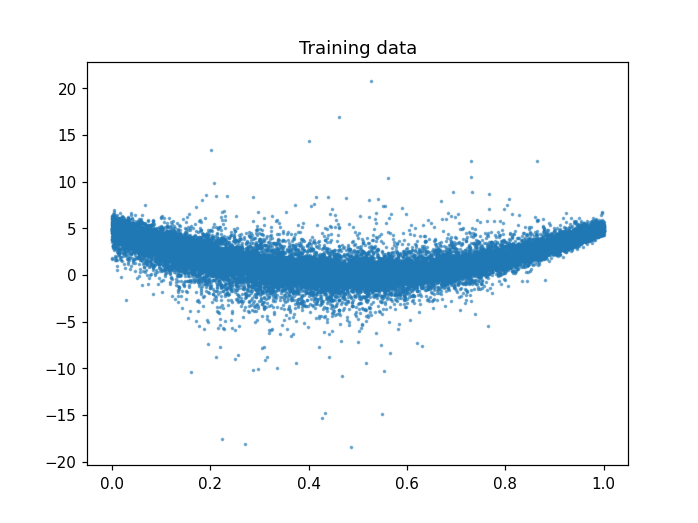

In [13]:
def f(x: float) -> tuple:
    """Function providing the 4 parameters (mu, beta, g, h) of the transformation applied to 
    a standard normal variable given the input x. Chosen arbitrarily for the simulation.
    """
    return 20 * (x - 0.5) ** 2, 1 + 3 * (x - 0.25)**2, 1 / 2 * (x - 0.5), np.maximum(0, 0.25 - (x - 0.5)**2)

def f_tdist(x:float) -> tuple:
    """Function providing the 3 parameters of the t-distribution for the misspecified section of
    the simulation study"""
    df = 1.5 * x + 2
    loc = 4 * x**2
    scale = 0.2 + (x - 0.5)**2
    return df, loc, scale
    

def tukey_g_h(z: float, theta: tuple):
    """Applies the tukey-g-h transform with parameters theta to z."""
    mu, beta, g, h = theta
    z_tilda = 1 / g * (np.exp(g * z) - 1) * np.exp(h * z**2 / 2)
    return mu + 1 / beta * z_tilda

def t_dist(z: float, theta):
    df, loc, scale = theta
    return t(df, loc, scale).rvs()

if MISSPECIFIED:
    f = f_tdist
    true_dist = t_dist
else:
    true_dist= tukey_g_h

x_data = np.random.rand(N_SAMPLES).astype(np.float32)
#x_data = np.random.rand(N_SAMPLES).astype(np.float32)

theta = f(x_data)

z = np.random.randn(N_SAMPLES).astype(np.float32)
y_data = true_dist(z, theta)

x_data, x_data_val = x_data[:TRAIN_SPLIT], x_data[TRAIN_SPLIT:]
y_data, y_data_val = y_data[:TRAIN_SPLIT], y_data[TRAIN_SPLIT:]

#y_data = t_dist(x_data)

%matplotlib notebook
import matplotlib as mpl
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x_data, y_data, s=2, alpha=0.5)
_ = ax.set_title('Training data')

## Training 

We declare a Tukey g-and-h loss and a Gaussian loss.

In [14]:
loss = losses.TuckeyGandHloss(n_target_channels=1, hmax=2)
loss_gaussian = losses.GaussianLoss(n_target_channels=1)

x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data).reshape((-1, 1))
x_val_torch, y_val_torch = torch.tensor(x_data_val).reshape((-1, 1)), torch.tensor(y_data_val).reshape((-1, 1))

dataset = TensorDataset(x_torch, y_torch)
dataset_val = TensorDataset(x_val_torch, y_val_torch)
optimizer = Adam(nn_parameters, lr=1e-4)
optimizer_gaussian = Adam(nn_gaussian_parameters, lr=1e-4)

scheduler = StepLR(optimizer, step_size=20, verbose=True)
scheduler_gaussian = StepLR(optimizer_gaussian, step_size=20, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.


In [15]:
tukey_losses = dict(train = [], val = [])
gaussian_losses = dict(train = [], val = [])

def train_for_one_epoch(nn, dataset):
    nn.train()
    nn_gaussian.train()
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    batch_losses = []
    batch_losses_gaussian = []
    for x, y in dataloader:
        optimizer.zero_grad()
        y_hat = nn(x)
        loss_y_yhat = loss(y_hat, y)
        loss_y_yhat.backward()
        optimizer.step()
        batch_losses.append(loss_y_yhat.detach().item())
        # gaussian
        optimizer_gaussian.zero_grad()
        y_hat = nn_gaussian(x)
        loss_y_yhat = loss_gaussian(y_hat, y)
        loss_y_yhat.backward()
        optimizer_gaussian.step()
        batch_losses_gaussian.append(loss_y_yhat.detach().item())
    print('Train losses: ', np.mean(batch_losses), np.mean(batch_losses_gaussian))
    tukey_losses['train'].append(np.mean(batch_losses))
    gaussian_losses['train'].append(np.mean(batch_losses_gaussian))
    scheduler.step()
    scheduler_gaussian.step()
    
    nn.eval()
    nn_gaussian.eval()
    dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False)
    batch_losses = []
    batch_losses_gaussian = []
    with torch.no_grad():
        for x, y in dataloader_val:
            y_hat = nn(x)
            loss_y_yhat = loss(y_hat, y)
            batch_losses.append(loss_y_yhat.detach().item())
            y_hat = nn_gaussian(x)
            loss_y_yhat = loss_gaussian(y_hat, y)
            batch_losses_gaussian.append(loss_y_yhat.detach().item())
    print('Validation losses: ', np.mean(batch_losses), np.mean(batch_losses_gaussian))
    tukey_losses['val'].append(np.mean(batch_losses))
    gaussian_losses['val'].append(np.mean(batch_losses_gaussian))



for i_epoch in range(N_EPOCHS):
    train_for_one_epoch(nn, dataset)

Train losses:  1.4282012842595577 1.3728702701628208
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Validation losses:  1.225444182753563 1.1588733941316605
Train losses:  1.1337984912097454 1.1152747496962547
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Validation losses:  1.070411965250969 1.0944561064243317
Train losses:  1.0411730222404003 1.0881365165114403
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Validation losses:  1.0035946369171143 1.072063371539116
Train losses:  0.9528381675481796 1.0611408445984125
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Validation losses:  0.8809259608387947 1.035526029765606
Train losses:  0.7751535065472126 1.009923154488206
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-04.
Validati

Train losses:  0.4075589394196868 0.537085771560669
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.4193147234618664 0.5342355333268642
Train losses:  0.4135591499507427 0.5415594410151243
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.4191942363977432 0.5334544815123081
Train losses:  0.4077877067029476 0.537345526739955
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.41920215263962746 0.5334252752363682
Train losses:  0.4094328647479415 0.5386723168194294
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.41921163722872734 0.5334645248949528
Train losses:  0.40952908899635077 0.5403531827032566
Adjusting learning rate of group 0 to 1.0000e-06.
Adjusting learning rate of group 0 to 1.0000e-06.
Va

## Plot losses 

<IPython.core.display.Javascript object>


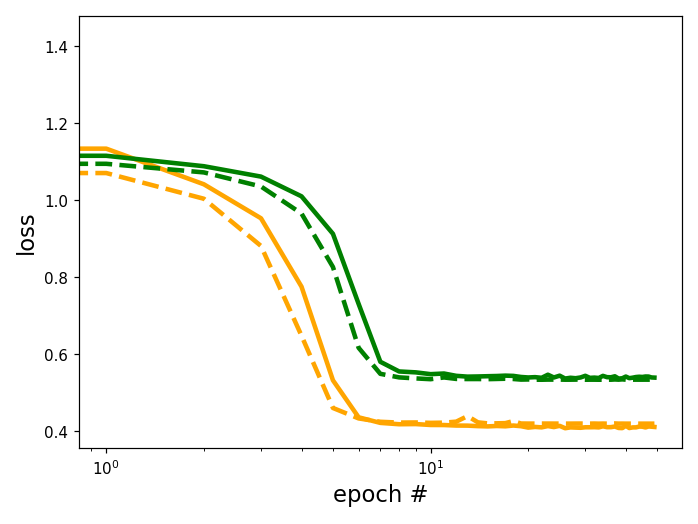

In [16]:
plt.figure()
plt.plot(tukey_losses['train'], color='orange', linewidth=3)
plt.plot(tukey_losses['val'], color='orange', linestyle='--', linewidth=3)

plt.plot(gaussian_losses['train'], color='green', linewidth=3)
plt.plot(gaussian_losses['val'], color='green', linestyle='--', linewidth=3)
plt.xscale('log')
plt.xlabel('epoch #', fontsize=15)
plt.ylabel('loss', fontsize=15)
#plt.ylim(None, 0.5)
plt.tight_layout()

plt.savefig('lossplot.png', dpi=800)

## Analysis 

For analysis, we plot the 4 functions of $x$ that make up the true model (solid lines) and the values predicted by the neural network (dashed lines).

<IPython.core.display.Javascript object>


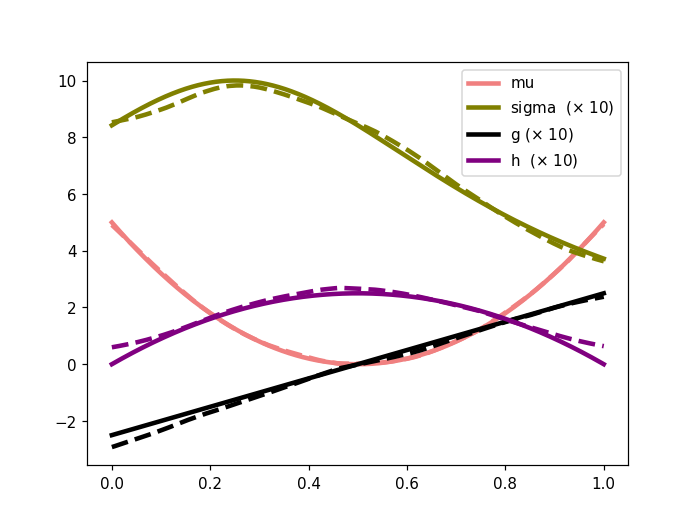

In [24]:
x_plot = np.linspace(min(x_data), max(x_data), 1000).astype(np.float32)
x_plot = x_plot.reshape((-1, 1))
# true regressed values
mu, beta, g, h = f(x_plot)

# predict g-and-h distributions for x_plot values
nn.eval()
with torch.no_grad():
    theta_plot = loss.predict(nn(torch.from_numpy(x_plot)))

mu_hat, beta_hat, g_hat, h_hat = theta_plot

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x_plot, mu, color='lightcoral', label='mu', linewidth=3)
ax.plot(x_plot, mu_hat, color='lightcoral', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 / beta, color='olive', label=r'sigma  ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 / beta_hat, color='olive', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 * g, color='k', label=r'g ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 *g_hat, color='k', linestyle='--', linewidth=3)

ax.plot(x_plot, 10 * h, color='purple', label=r'h  ($\times$ 10)', linewidth=3)
ax.plot(x_plot, 10 * h_hat, color='purple', linestyle='--', linewidth=3)

ax.legend()

#ax.set_title('test')
plt.savefig('tukey1.png', dpi=800)

We now plot the true conditional distributions for 4 values of the feature $x$ (blue), the G-and-H distribution predicted by the neural network for these same 4 values of the feature (orange), and the Gaussian distributions predicted by a separate neural network trained for that purpose using negative Gaussian likelihood for the loss function (green)

<IPython.core.display.Javascript object>


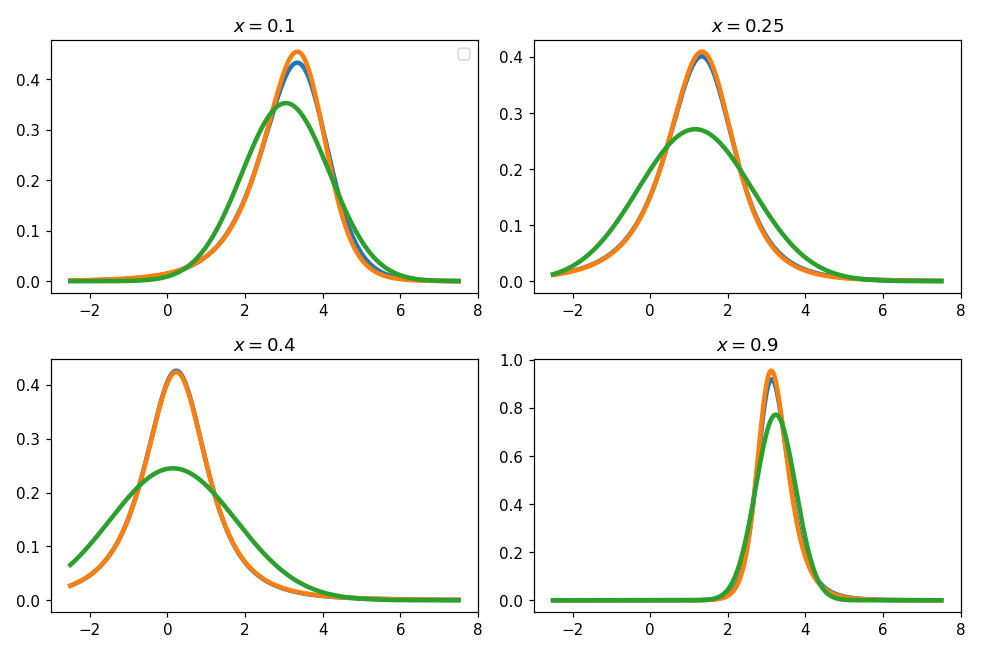

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [40]:
from tukey.utils import compute_pdf_tukey
from scipy.stats import norm

x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(9, 6))
z_tildas = torch.linspace(-2.5, 7.5, 1000)


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(2, 2, i + 1)
    x = x_0

    theta_true = f(x)
    with torch.no_grad():
        theta_pred = tuple([a.item() for a in loss.predict(nn(torch.tensor(x).reshape((-1, 1))))])
        theta_gaussian_pred = tuple([a.item() 
                                     for a in loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))])

    # true
    if not MISSPECIFIED:
        zz = (z_tildas - theta_true[0]) * theta_true[1]
        pdf_true = compute_pdf_tukey(zz, theta_true[2], theta_true[3]) * theta_true[1]
        plt.plot(z_tildas, pdf_true, linewidth=3)
    else:
        true_dist = t(df=theta_true[0], loc=theta_true[1], scale=theta_true[2])
        plt.plot(z_tildas, true_dist.pdf(z_tildas), linewidth=3)
    # pred tukey
    zz = (z_tildas - theta_pred[0]) * theta_pred[1]
    pdf_pred = compute_pdf_tukey(zz, theta_pred[2], theta_pred[3]) * theta_pred[1]
    plt.plot(z_tildas, pdf_pred, linewidth=3)
    # pred gaussian
    zz = (z_tildas - theta_gaussian_pred[0]) * theta_gaussian_pred[1]
    pdf_gaussian = norm.pdf(zz) * theta_gaussian_pred[1]
    plt.plot(z_tildas, pdf_gaussian, linewidth=3)
    #ax.set_yscale('log')
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()
if MISSPECIFIED:
    plt.savefig('tukey2bis.png', dpi=800)
else:
    plt.savefig('tukey2.png', dpi=800)

<IPython.core.display.Javascript object>


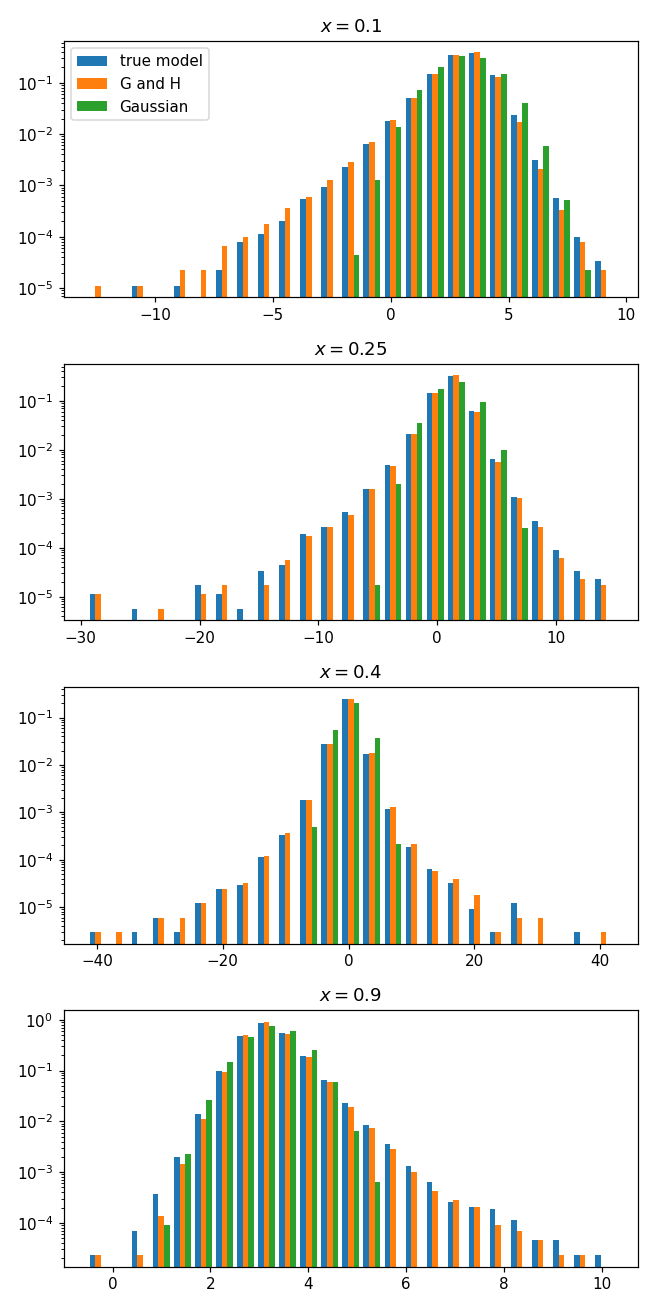

In [41]:
from tukey.utils import compute_pdf_tukey

n_points = 100000
x_0s = [0.1, 0.25, 0.4, 0.9]
fig = plt.figure(figsize=(6, 12))


for i, x_0 in enumerate(x_0s):
    ax = fig.add_subplot(4, 1, i + 1)
    x = x_0 * np.ones(n_points, dtype=np.float32).reshape((-1, 1))
    z = np.random.randn(n_points).reshape((-1, 1))
    z2 = np.random.randn(n_points).reshape((-1, 1))


    theta_true = f(x)
    with torch.no_grad():
        theta_pred = loss.predict(nn(torch.tensor(x).reshape((-1, 1))))
        theta_gaussian_pred = loss_gaussian.predict(nn_gaussian(torch.tensor(x).reshape((-1, 1))))
    y_true = true_dist(z, theta_true)
    #y_true = t_dist(x.reshape((1, -1))).reshape((-1, 1))

    y_pred = tukey_g_h(z, theta_pred)
    y_gaussian_pred = theta_gaussian_pred[0] + 1 / theta_gaussian_pred[1] * z

    ax.hist(np.hstack((y_true, y_pred, y_gaussian_pred)), 
            bins=25, density=True, cumulative=False, log=True,
            label=('true model', 'G and H', 'Gaussian'))
    ax.set_title(f'$x={x_0}$')
    if i == 0:
        plt.legend()
fig.tight_layout()

For a more rigurous analysis, we can compare the distribution of the $\hat{z}_i$'s to that of a standard normal.

In [42]:
import tukey.losses as ll

with torch.no_grad():
    theta_hat = loss.predict(nn(torch.from_numpy(x_data_val.reshape((-1, 1)))))
    mu, beta, g, h = theta_hat
    z_tilda = (torch.from_numpy(y_data_val.reshape((-1, 1))) - mu) * beta
    z_hat = ll.Tuckey_g_h_inverse.forward(None, z_tilda, g, h)

z_hat = z_hat.numpy()

<IPython.core.display.Javascript object>


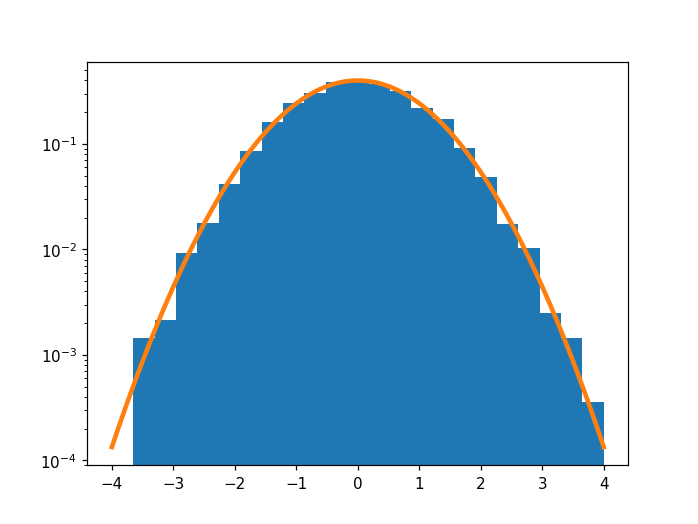

In [43]:
from scipy.stats import norm

plt.figure()
plt.hist(z_hat, bins=np.linspace(-4, 4, 24), density=True)
plt.plot(np.linspace(-4, 4, 100), norm.pdf(np.linspace(-4, 4, 100)), linewidth=3)
plt.yscale('log')
plt.savefig('residual_t.jpg', dpi=800)

We do a QQ plot to compare to the standard normal distribution.

<IPython.core.display.Javascript object>


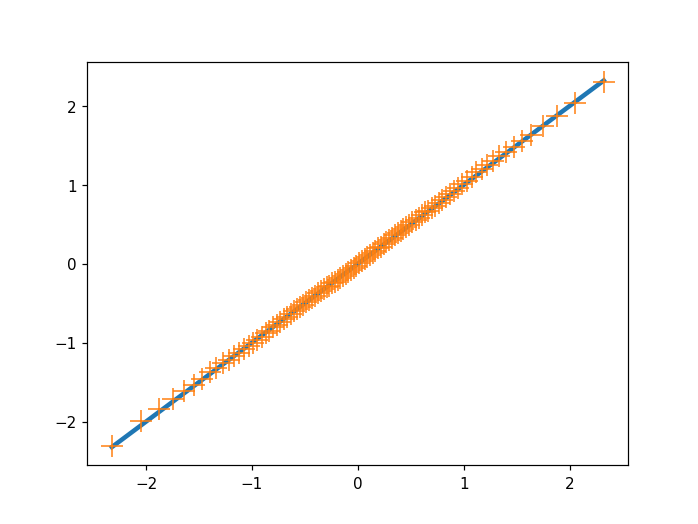

In [44]:
q = np.linspace(0, 1, 100)[1: -1]
true_quantiles = norm.ppf(q)
data_quantiles = np.quantile(z_hat, q)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(true_quantiles, true_quantiles, linewidth=3)
ax.plot(true_quantiles, data_quantiles, '+', markersize=15)

## Prediction confidence intervals 

One can easily obtain prediction confidence intervals from the trained neural network (even though these are not as rigurous as prediction confidence intervals understood in statistical terms, where one also accounts for the uncertainty in the parameter estimates - here this would correspond to the uncertainty in the parameters of the neural network, which could be approached by Bayesian NN or Bootstrapping??).

In [45]:
confidence_level = 0.5
x_plot = np.linspace(min(x_data), max(x_data), 256).astype(np.float32).reshape((-1, 1))

<IPython.core.display.Javascript object>


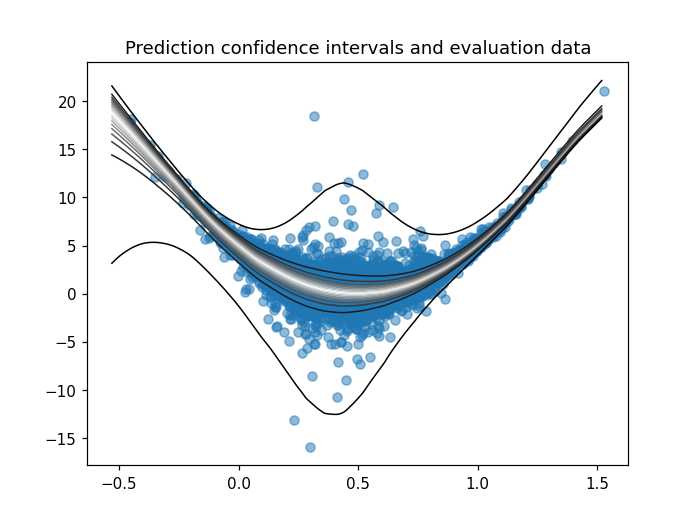

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [54]:
plt.figure()

for confidence_level in np.linspace(0.001, 0.999, 10):
    with torch.no_grad():
        lb, ub = loss.predict_ci(nn(torch.from_numpy(x_plot)), confidence_level)
        lb = lb.numpy()
        ub = ub.numpy()
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

## Bootstrapping prediction confidence intervals 

Our prediction confidence intervals are not prediction confidence intervals in the usual statistical sense, as we do not account for the uncertainty in parameter estimates (here the parameters of the neural network).
One way we might approach this is via bootstrapping - we simulate new values using the fitted distributions, train the neural network on those new values.

In [48]:
import copy
n_boot = 5  # number of bootstrap neural networks
nn_boots = [] # list to keep references to bootstrap neural networks

for i_boot in range(n_boot):
    print(f'############{i_boot}')
    nn_boot = copy.deepcopy(nn)  # we start from the trained nn
    nn_boots.append(nn_boot)
    
    # simulate bootstrap data from the trained model
    nn.eval()
    with torch.no_grad():
        theta_hat = loss.predict(nn(torch.from_numpy(x_data).reshape((-1, 1))))
        theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

    x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
    dataset_boot = TensorDataset(x_torch, y_torch)
    
    # train the bootstrap neural network on bootstrap data
    for i_epoch in range(5):
        optimizer = Adam(nn_boot.parameters(), lr=1e-4)
        scheduler = StepLR(optimizer, step_size=20, verbose=True)
        epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)

############0
Adjusting learning rate of group 0 to 1.0000e-04.
Train losses:  0.49683166688335995 0.6199891585833766
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.47921816259622574 0.6037288382649422
Adjusting learning rate of group 0 to 1.0000e-04.
Train losses:  0.48974909984335363 0.6222417330320162
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.4764644019305706 0.6037740334868431
Adjusting learning rate of group 0 to 1.0000e-04.
Train losses:  0.4924157627942942 0.6159589164924286
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-06.
Validation losses:  0.479169812053442 0.60375015437603
Adjusting learning rate of group 0 to 1.0000e-04.
Train losses:  0.48997782954920416 0.6225661743274972
Adjusting learning rate of group 0 to 1.0000e-04.
Adjusting learning rate of group 0 to 1.0000e-06.

<IPython.core.display.Javascript object>


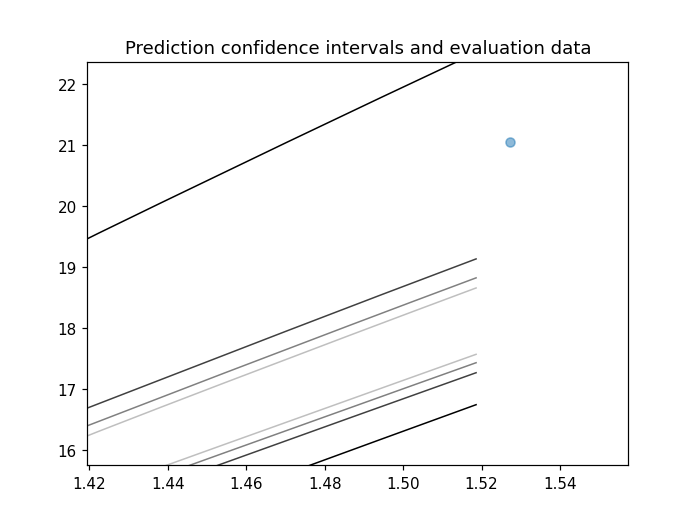

Text(0.5, 1.0, 'Prediction confidence intervals and evaluation data')

In [53]:
plt.figure()

for confidence_level in np.linspace(0.001, 0.999, 5):
    lbs, ubs = [], []
    for nn_boot in nn_boots:
        with torch.no_grad():
            lb, ub = loss.predict_ci(nn_boot(torch.from_numpy(x_plot)), confidence_level)
            lb = lb.numpy()
            ub = ub.numpy()
        lbs.append(lb)
        ubs.append(ub)
    lbs = np.stack(lbs, axis=0)
    ubs = np.stack(ubs, axis=0)
    # currently we use the min but incorrect
    lb = np.min(lbs, axis=0)
    ub = np.max(ubs, axis=0)
    color = (1 - confidence_level, ) * 3
    plt.plot(x_plot, lb, color=color, linewidth=1)
    plt.plot(x_plot, ub, color=color, linewidth=1)

plt.scatter(x_data_val, y_data_val, zorder=1, alpha=0.5)
plt.title('Prediction confidence intervals and evaluation data')

In [16]:
lbs.shape

(10, 256, 1)

In [17]:
ubs[:, 0, :]

array([[19.000881],
       [19.067373],
       [18.819538],
       [20.231125],
       [21.326546],
       [18.809288],
       [21.90679 ],
       [21.010126],
       [21.461197],
       [20.22324 ]], dtype=float32)

Here we define a proper class to implement the bootstrapped prediction confidence intervals

In [18]:
from torch.nn import Module

class Bootstrapped:
    def __init__(self, loss, trained_model: Module, n_bootstraps: int):
        self.loss = loss
        self.trained_model = trained_model
        self.n_bootstraps = n_bootstraps
        self.boot_models = []

    def generate_bootstrap_data(self, x_data: np.ndarray):
        """
        Generate bootstrap data using the passed features and the 
        conditional distributions corresponding to the trained neural
        network.
        """
        self.trained_model.eval()
        with torch.no_grad():
            x_data = torch.from_numpy(x_data).reshape((-1, 1))
            theta_hat = loss.predict(self.trained_model(x_data))
            theta_hat = [v.numpy() for v in theta_hat]
        y_data_boot = tukey_g_h(np.random.randn(*x_data.shape).reshape((-1, 1)), theta_hat)

        x_torch, y_torch = torch.tensor(x_data).reshape((-1, 1)), torch.tensor(y_data_boot).reshape((-1, 1))
        dataset_boot = TensorDataset(x_torch, y_torch)
        return dataset_boot
    
    def train(self, x: np.ndarray):
        """
        Train the bootstrap neural networks on bootstrap data from
        the trained model.
        """
        for i_boot in range(self.n_bootstraps):
            nn_boot = copy.deepcopy(self.trained_model)  # we start from the trained nn
            self.boot_models.append(nn_boot)

            # simulate bootstrap data from the trained model
            dataset_boot = self.generate_bootstrap_data(x)

            # train the bootstrap neural network on bootstrap data
            for i_epoch in range(20):
                optimizer = Adam(nn_boot.parameters(), lr=1e-4)
                epoch_loss = train_for_one_epoch(nn_boot, dataset_boot)
        
    def cumulative(self, x, y):
        """
        Provide the cumulative distribution function of predictions
        based on the bootstrapped neural networks.
        """
        raise NotImplementedError()

    def confidence_interval(self, x, level: float):
        """
        Provide prediction confidence intervals.
        """
        

## Coverage analysis 

In [28]:
n_simulations = 10000

x_data = np.linspace(-0.5, 1.5, 1000).reshape((-1, 1)).astype(np.float32)
theta = f(x_data)

z = np.random.randn(x_data.shape[0], n_simulations).astype(np.float32)
y_data = tukey_g_h(z, theta)
y_data.shape

(1000, 10000)

<IPython.core.display.Javascript object>


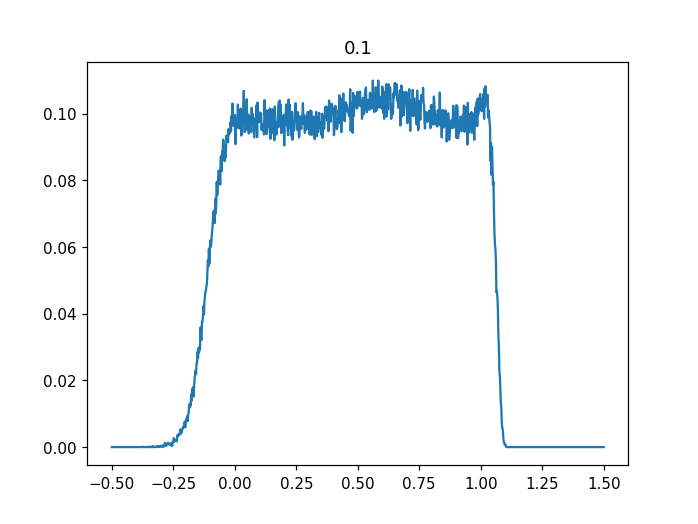

<IPython.core.display.Javascript object>


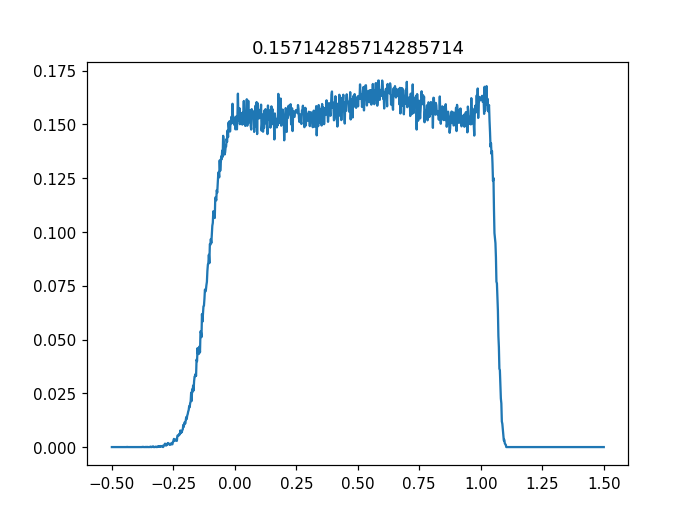

<IPython.core.display.Javascript object>


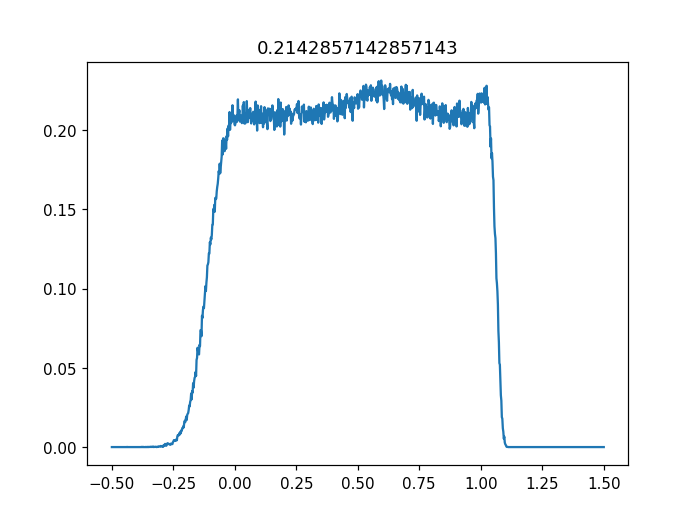

<IPython.core.display.Javascript object>


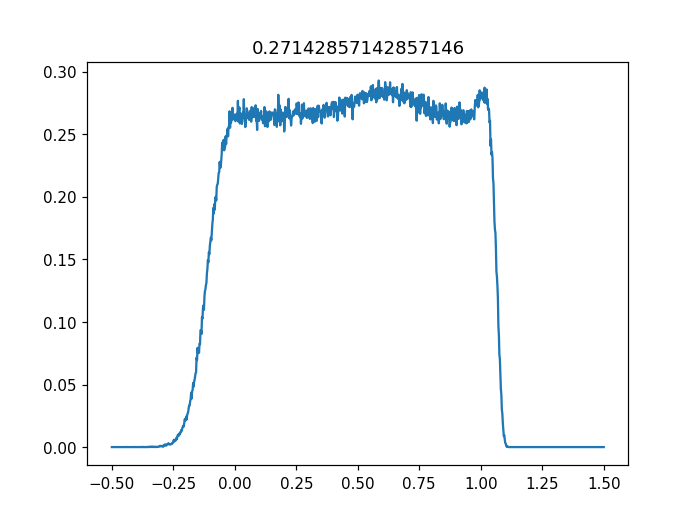

<IPython.core.display.Javascript object>


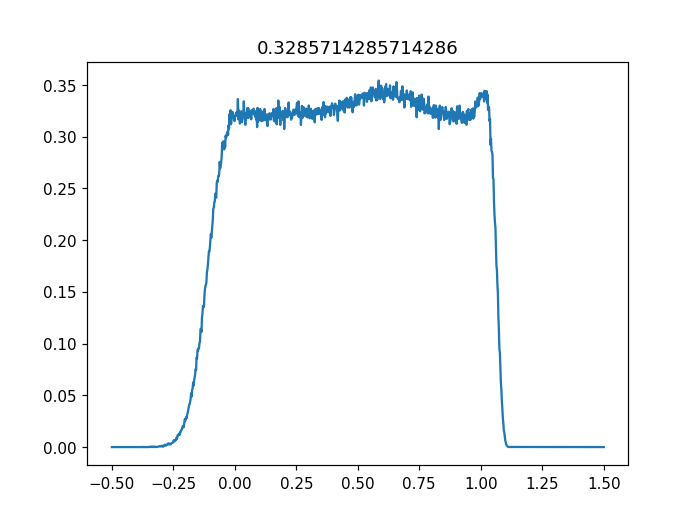

<IPython.core.display.Javascript object>


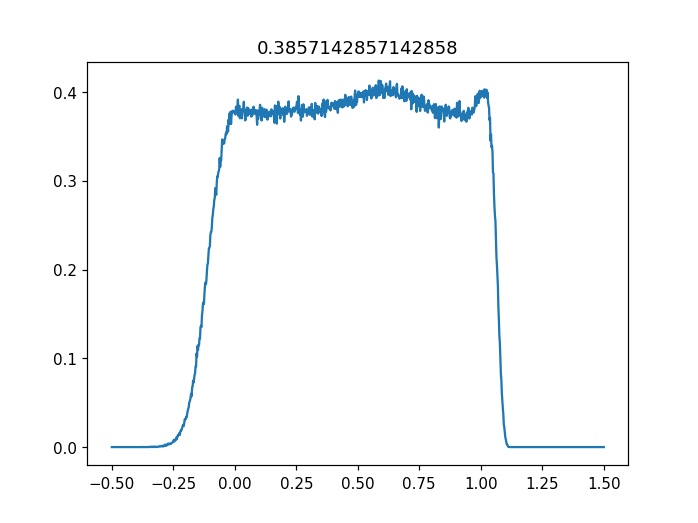

<IPython.core.display.Javascript object>


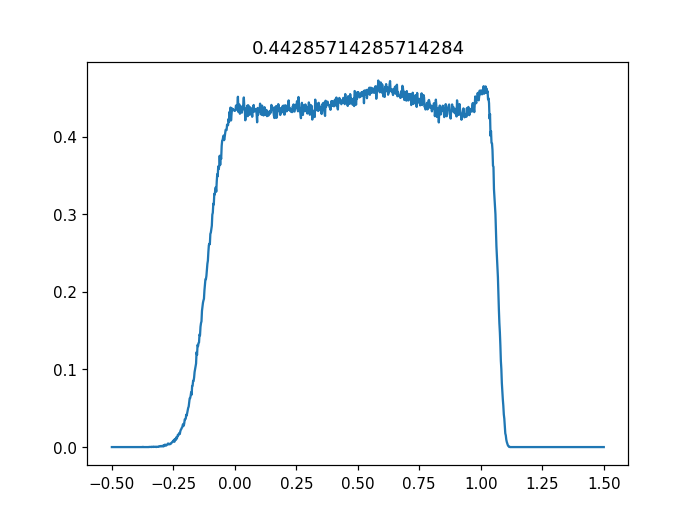

<IPython.core.display.Javascript object>


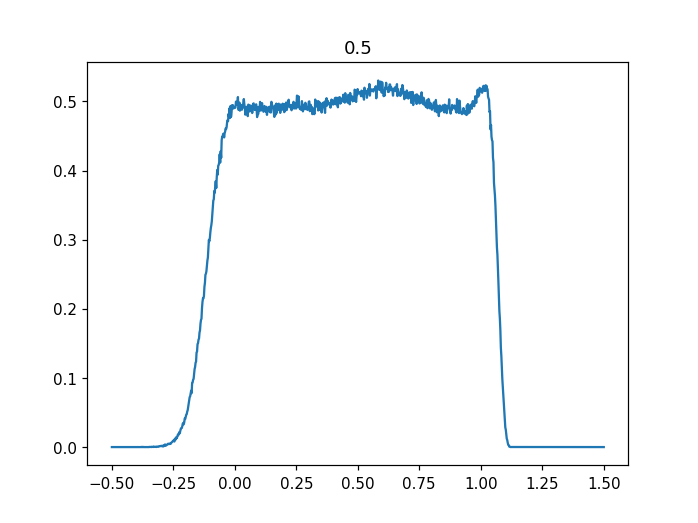

<IPython.core.display.Javascript object>


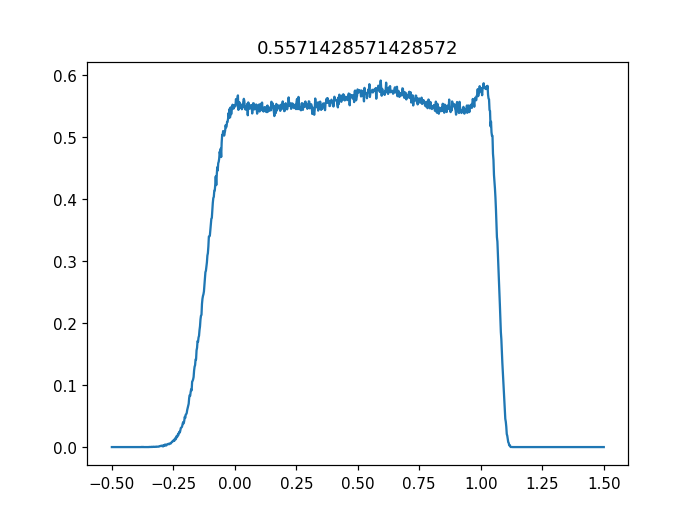

<IPython.core.display.Javascript object>


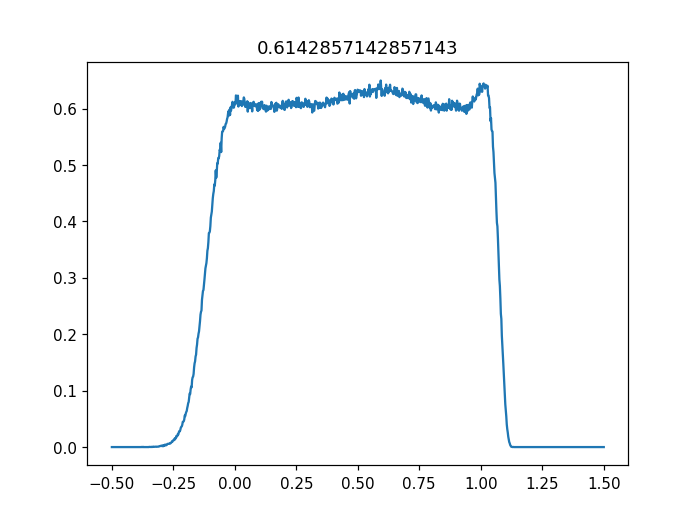

<IPython.core.display.Javascript object>


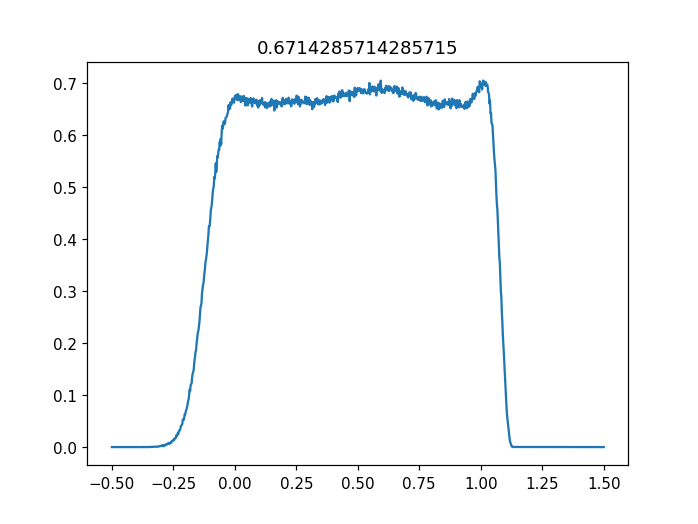

/tmp/3299005.1.short.q/ipykernel_30527/850180366.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


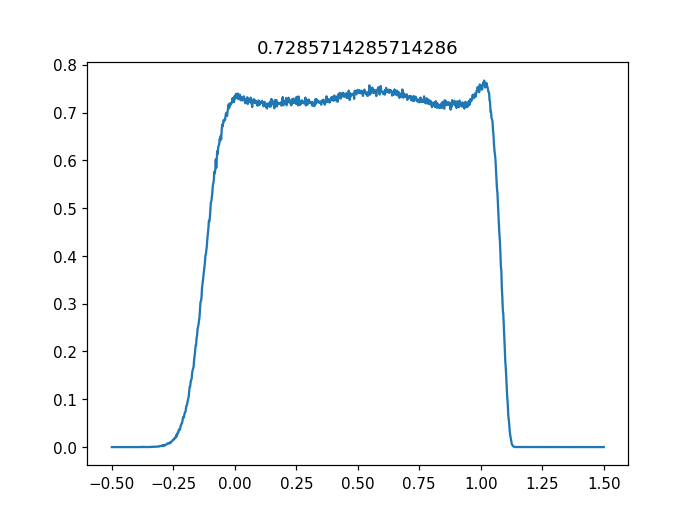

<IPython.core.display.Javascript object>


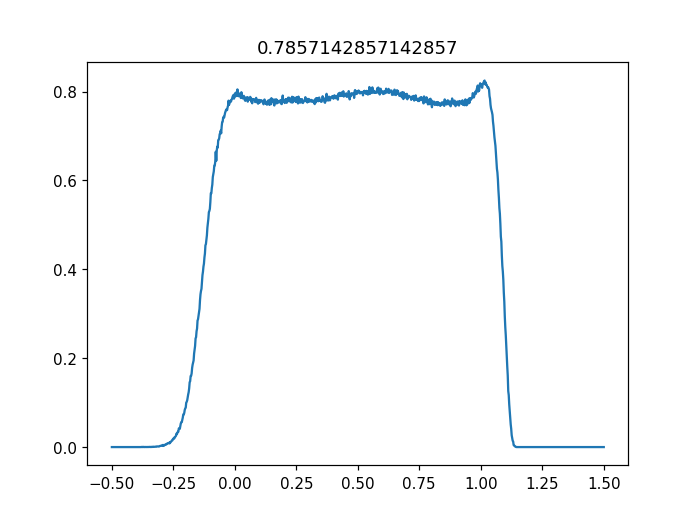

<IPython.core.display.Javascript object>


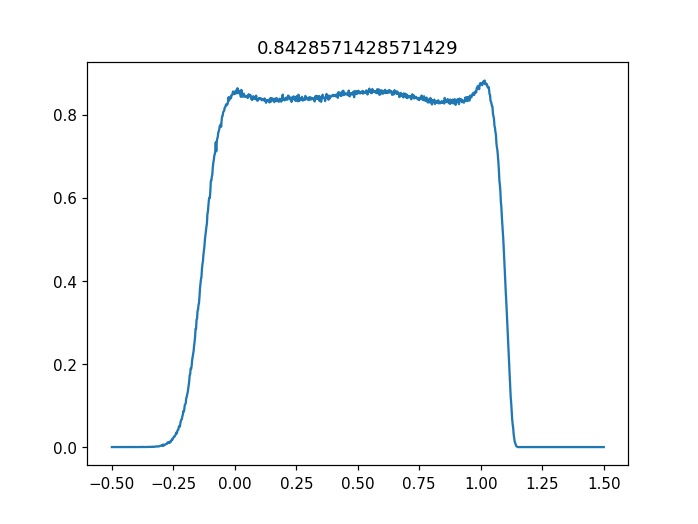

<IPython.core.display.Javascript object>


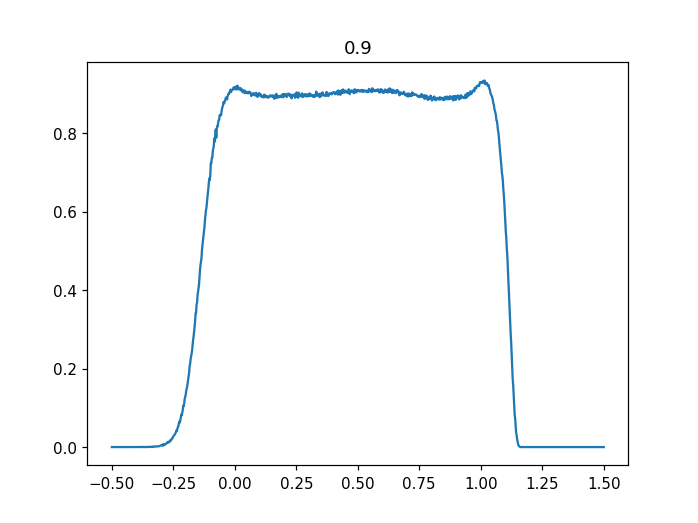

In [29]:
for confidence_level in np.linspace(0.1, 0.9, 15):
    with torch.no_grad():
        lb, ub = loss.predict_ci(nn(torch.from_numpy(x_data)), confidence_level)
        lb = lb.numpy()
        ub = ub.numpy()
        percentage = np.mean((y_data >= lb) & (y_data <= ub), axis=-1)
        plt.figure()
        plt.plot(x_data,percentage)
        plt.title(confidence_level)

<IPython.core.display.Javascript object>


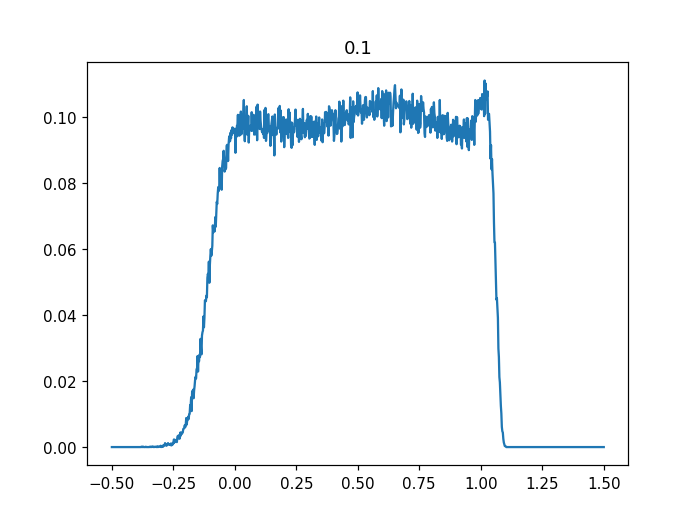

<IPython.core.display.Javascript object>


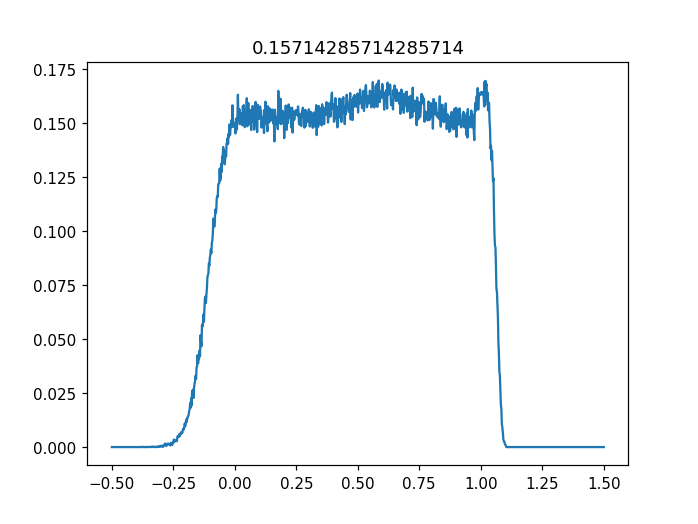

<IPython.core.display.Javascript object>


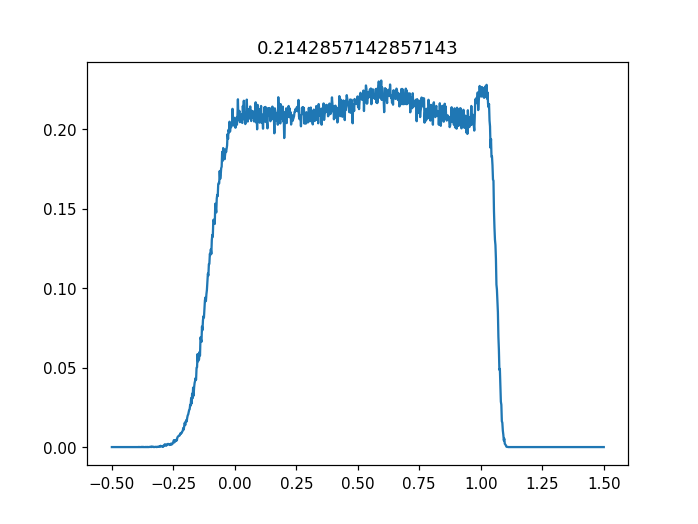

<IPython.core.display.Javascript object>


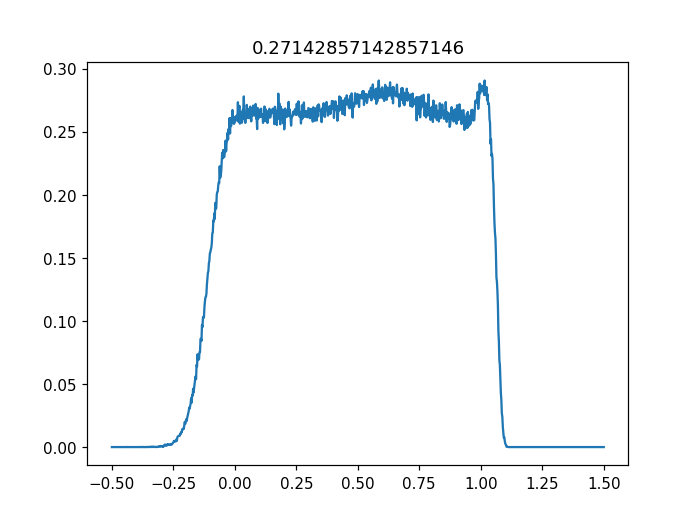

<IPython.core.display.Javascript object>


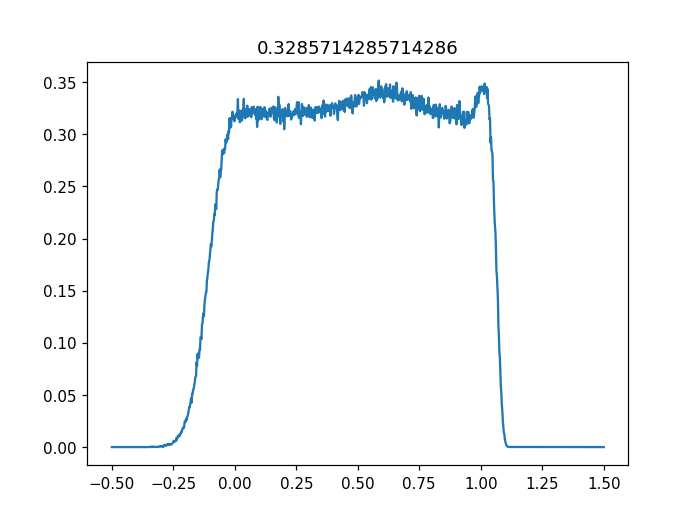

<IPython.core.display.Javascript object>


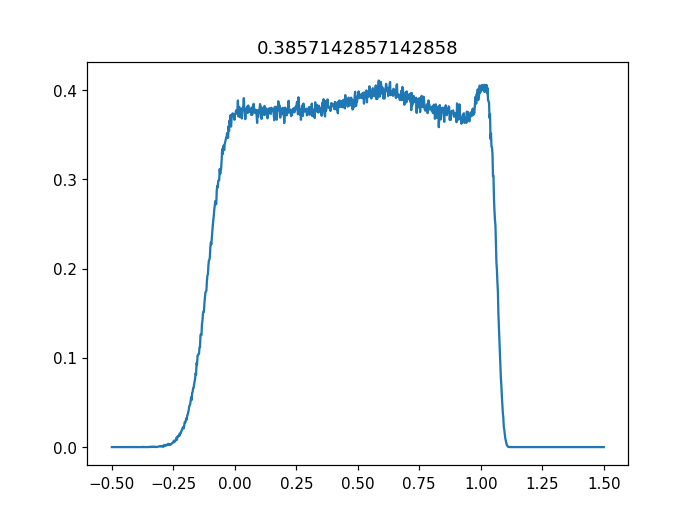

<IPython.core.display.Javascript object>


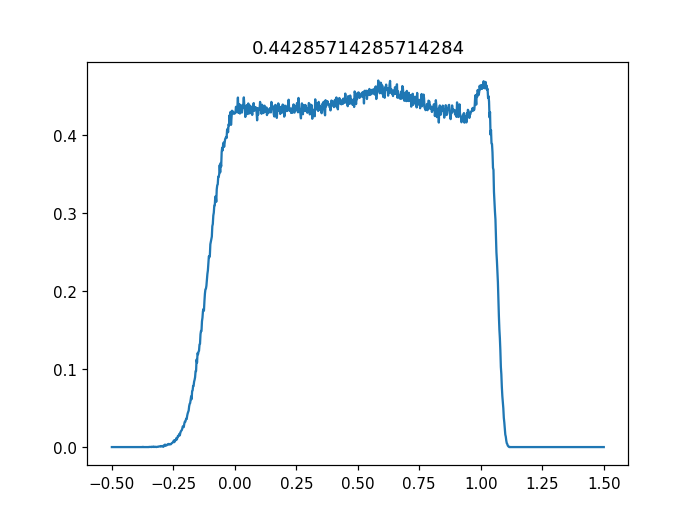

<IPython.core.display.Javascript object>


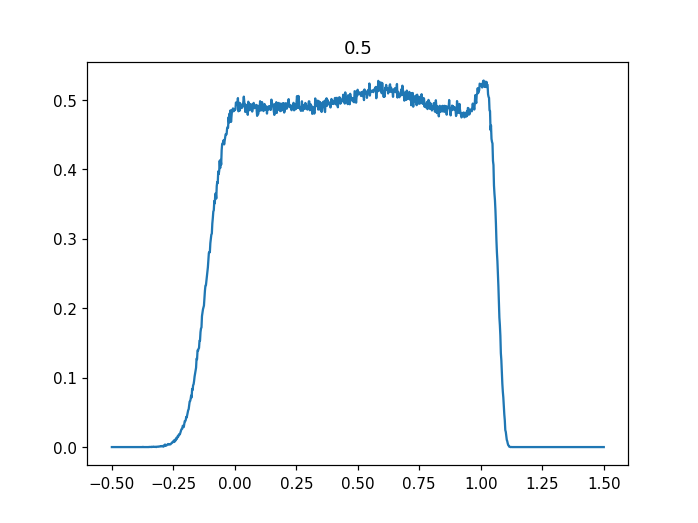

<IPython.core.display.Javascript object>


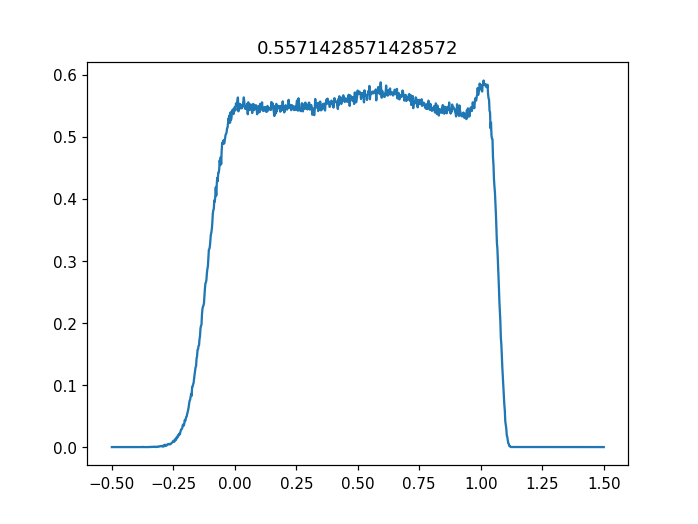

<IPython.core.display.Javascript object>


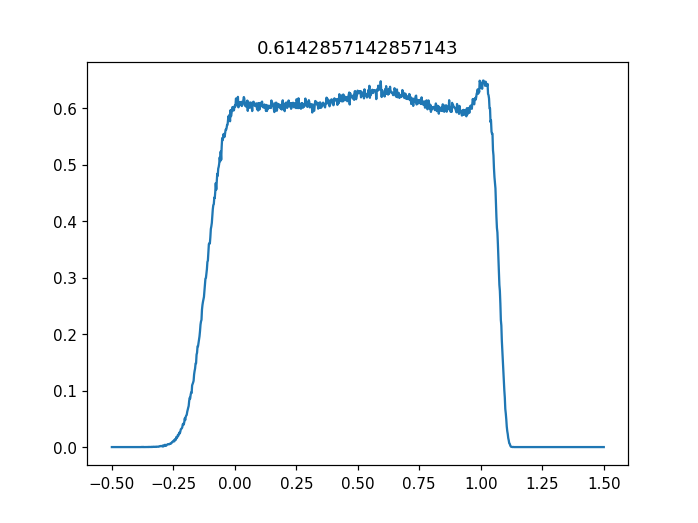

<IPython.core.display.Javascript object>


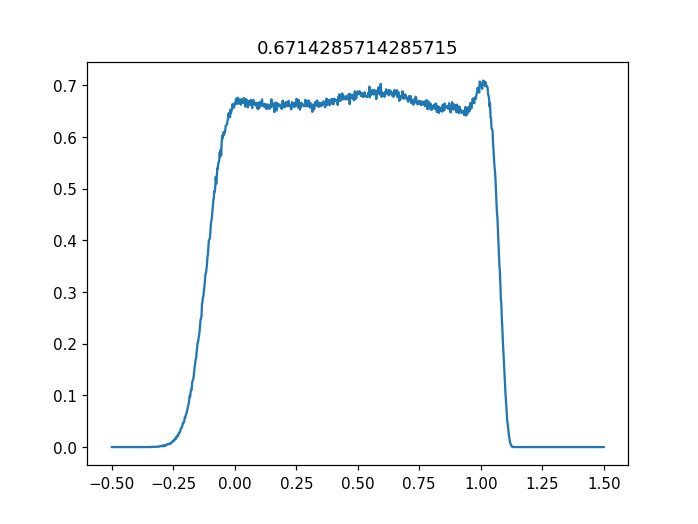

<IPython.core.display.Javascript object>


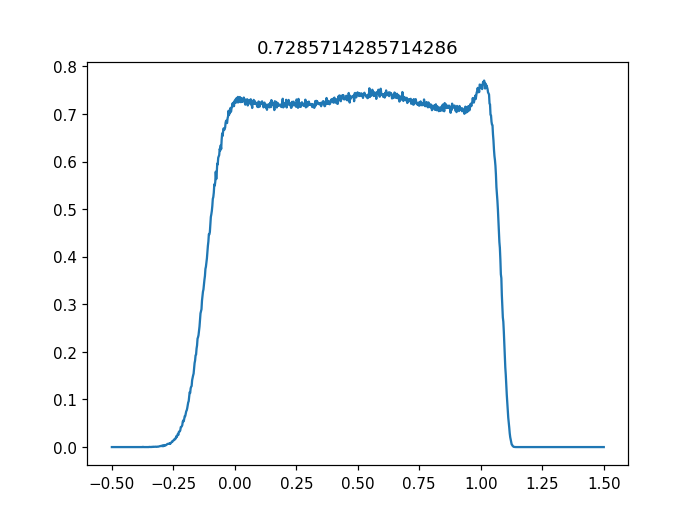

<IPython.core.display.Javascript object>


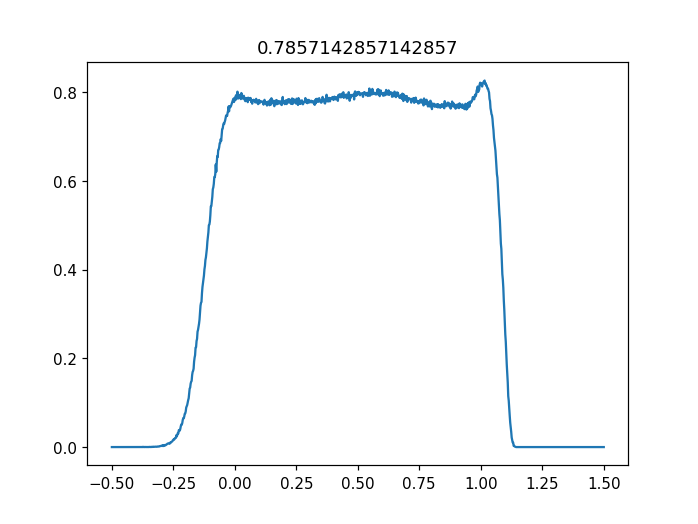

<IPython.core.display.Javascript object>


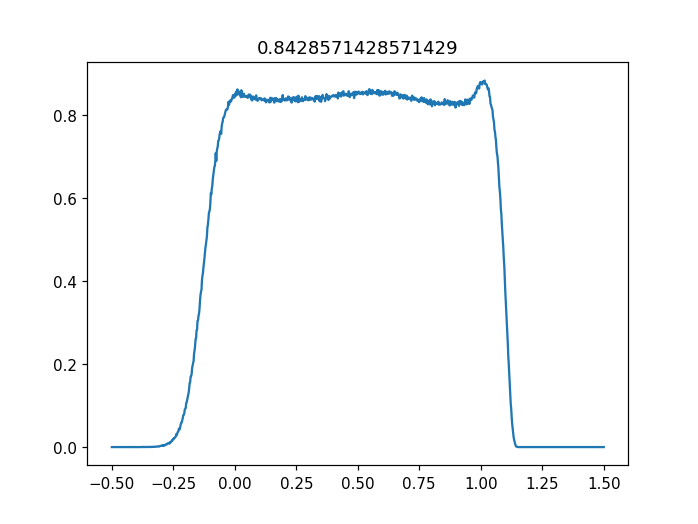

<IPython.core.display.Javascript object>


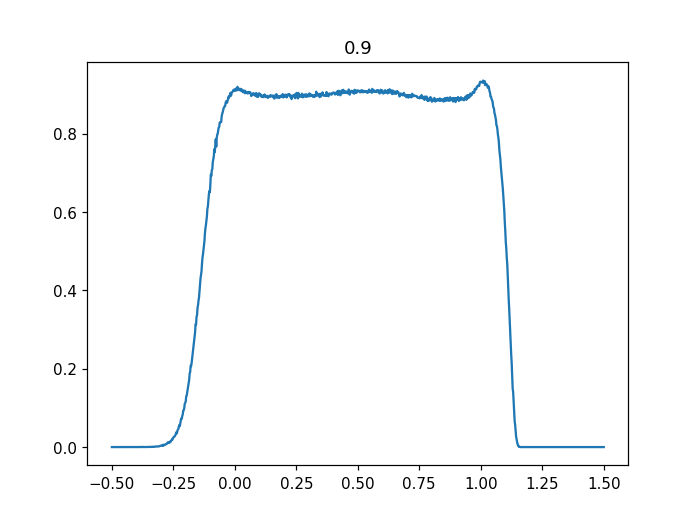

In [30]:
for confidence_level in np.linspace(0.1, 0.9, 15):
    lbs, ubs = [], []
    for nn_boot in nn_boots:
        with torch.no_grad():
            lb, ub = loss.predict_ci(nn_boot(torch.from_numpy(x_data)), confidence_level)
            lb = lb.numpy()
            ub = ub.numpy()
        lbs.append(lb)
        ubs.append(ub)
    lbs = np.stack(lbs, axis=0)
    ubs = np.stack(ubs, axis=0)
    # currently we use the min but incorrect
    lb = np.mean(lbs, axis=0)
    ub = np.mean(ubs, axis=0)
    percentage = np.mean((y_data >= lb) & (y_data <= ub), axis=-1)
    plt.figure()
    plt.plot(x_data,percentage)
    plt.title(confidence_level)